In [2]:
%ls

 D 드라이브의 볼륨: 새 볼륨
 볼륨 일련 번호: F4BA-B9E5

 d:\Workspace\Deep-Learning\05. GAN 디렉터리

2020-07-15  오후 01:25    <DIR>          .
2020-07-15  오후 01:25    <DIR>          ..
2020-07-15  오후 01:21    <DIR>          .ipynb_checkpoints
2020-07-15  오후 01:22               555 01. GAN.ipynb
2020-07-15  오후 01:25             4,646 GAN.py
               2개 파일               5,201 바이트
               3개 디렉터리  972,874,969,088 바이트 남음


In [2]:
import plaidml.keras
plaidml.keras.install_backend()
import tensorflow as tf
import keras

In [3]:
tf.__version__

'2.1.0'

In [4]:
keras.__version__

'2.2.4'

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [6]:
import os
if not os.path.exists("../images/gan"):
    os.makedirs("../images/gan")

In [7]:
np.random.seed(3)
tf.random.set_seed(3)  

In [8]:
#생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [9]:
#판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')

discriminator.trainable = False

In [10]:
#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [14]:
#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):
    # MNIST 데이터 불러오기

    (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_train = (X_train - 127.5) / 127.5  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력하는 부분입니다.
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
        if i % saving_interval == 0:
              #r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("../images/gan/gan_mnist_%d.png" % i)

epoch:0  d_loss:0.4348  g_loss:0.3323
epoch:1  d_loss:0.5262  g_loss:0.0932
epoch:2  d_loss:0.6705  g_loss:0.0513
epoch:3  d_loss:0.6642  g_loss:0.1118
epoch:4  d_loss:0.5488  g_loss:0.3087
epoch:5  d_loss:0.4993  g_loss:0.6583
epoch:6  d_loss:0.5315  g_loss:0.8210
epoch:7  d_loss:0.5428  g_loss:0.8780
epoch:8  d_loss:0.4937  g_loss:0.8563
epoch:9  d_loss:0.4220  g_loss:0.9042
epoch:10  d_loss:0.4146  g_loss:0.9349
epoch:11  d_loss:0.4520  g_loss:0.8685
epoch:12  d_loss:0.4359  g_loss:0.9050
epoch:13  d_loss:0.5573  g_loss:1.0459
epoch:14  d_loss:0.5896  g_loss:1.1321
epoch:15  d_loss:0.5708  g_loss:1.3070
epoch:16  d_loss:0.5925  g_loss:1.0457
epoch:17  d_loss:0.5405  g_loss:1.1414
epoch:18  d_loss:0.6787  g_loss:0.8395
epoch:19  d_loss:0.5243  g_loss:0.7340
epoch:20  d_loss:0.5164  g_loss:0.6915
epoch:21  d_loss:0.4379  g_loss:0.8568
epoch:22  d_loss:0.4648  g_loss:0.9187
epoch:23  d_loss:0.5353  g_loss:0.9329
epoch:24  d_loss:0.5177  g_loss:0.8926
epoch:25  d_loss:0.5520  g_loss:0.7

epoch:208  d_loss:0.3619  g_loss:2.2302
epoch:209  d_loss:0.4370  g_loss:2.3199
epoch:210  d_loss:0.4289  g_loss:2.5091
epoch:211  d_loss:0.5131  g_loss:2.6070
epoch:212  d_loss:0.4726  g_loss:1.9324
epoch:213  d_loss:0.2852  g_loss:2.1191
epoch:214  d_loss:0.4565  g_loss:2.0536
epoch:215  d_loss:0.3982  g_loss:1.9839
epoch:216  d_loss:0.4171  g_loss:2.1607
epoch:217  d_loss:0.4990  g_loss:2.1159
epoch:218  d_loss:0.5769  g_loss:1.7534
epoch:219  d_loss:0.6001  g_loss:1.6865
epoch:220  d_loss:0.7476  g_loss:1.2127
epoch:221  d_loss:0.7899  g_loss:1.4026
epoch:222  d_loss:0.7991  g_loss:1.4154
epoch:223  d_loss:0.7192  g_loss:1.7399
epoch:224  d_loss:0.8438  g_loss:2.2264
epoch:225  d_loss:0.7510  g_loss:1.6942
epoch:226  d_loss:0.7661  g_loss:1.5618
epoch:227  d_loss:0.9401  g_loss:1.2821
epoch:228  d_loss:0.9725  g_loss:1.1690
epoch:229  d_loss:0.7772  g_loss:1.2349
epoch:230  d_loss:0.6669  g_loss:1.1597
epoch:231  d_loss:0.6267  g_loss:1.6799
epoch:232  d_loss:0.4963  g_loss:1.9757


epoch:413  d_loss:0.2470  g_loss:2.7745
epoch:414  d_loss:0.2097  g_loss:2.5813
epoch:415  d_loss:0.2167  g_loss:2.6786
epoch:416  d_loss:0.3328  g_loss:2.6933
epoch:417  d_loss:0.1969  g_loss:2.2627
epoch:418  d_loss:0.2116  g_loss:2.3003
epoch:419  d_loss:0.1708  g_loss:2.3938
epoch:420  d_loss:0.2550  g_loss:2.8278
epoch:421  d_loss:0.2614  g_loss:3.0531
epoch:422  d_loss:0.2064  g_loss:3.3216
epoch:423  d_loss:0.2237  g_loss:2.9910
epoch:424  d_loss:0.2363  g_loss:2.9018
epoch:425  d_loss:0.3640  g_loss:2.0484
epoch:426  d_loss:0.2625  g_loss:2.2667
epoch:427  d_loss:0.3227  g_loss:2.2848
epoch:428  d_loss:0.1931  g_loss:2.6369
epoch:429  d_loss:0.2274  g_loss:3.0087
epoch:430  d_loss:0.2213  g_loss:2.6104
epoch:431  d_loss:0.3427  g_loss:2.8618
epoch:432  d_loss:0.2772  g_loss:2.5320
epoch:433  d_loss:0.1879  g_loss:2.8734
epoch:434  d_loss:0.2921  g_loss:1.9901
epoch:435  d_loss:0.3222  g_loss:2.1350
epoch:436  d_loss:0.2335  g_loss:2.1366
epoch:437  d_loss:0.2552  g_loss:3.3251


epoch:618  d_loss:0.6905  g_loss:1.5943
epoch:619  d_loss:0.2370  g_loss:4.1678
epoch:620  d_loss:0.1543  g_loss:7.4793
epoch:621  d_loss:0.2859  g_loss:7.3678
epoch:622  d_loss:0.4528  g_loss:3.4775
epoch:623  d_loss:0.7522  g_loss:1.6143
epoch:624  d_loss:1.6800  g_loss:0.6013
epoch:625  d_loss:1.5378  g_loss:0.7548
epoch:626  d_loss:0.9373  g_loss:1.4895
epoch:627  d_loss:0.6418  g_loss:2.8830
epoch:628  d_loss:0.7997  g_loss:3.3554
epoch:629  d_loss:0.5916  g_loss:3.3519
epoch:630  d_loss:0.3927  g_loss:3.4604
epoch:631  d_loss:0.3227  g_loss:3.8949
epoch:632  d_loss:0.6181  g_loss:3.6464
epoch:633  d_loss:0.5171  g_loss:2.9265
epoch:634  d_loss:0.5839  g_loss:2.4519
epoch:635  d_loss:0.5602  g_loss:2.8775
epoch:636  d_loss:0.5387  g_loss:2.2016
epoch:637  d_loss:0.3240  g_loss:2.4326
epoch:638  d_loss:0.4089  g_loss:2.5053
epoch:639  d_loss:0.3871  g_loss:2.8357
epoch:640  d_loss:0.3628  g_loss:2.4253
epoch:641  d_loss:0.3423  g_loss:2.6836
epoch:642  d_loss:0.5125  g_loss:2.2145


epoch:823  d_loss:0.4574  g_loss:2.5842
epoch:824  d_loss:0.3275  g_loss:2.7387
epoch:825  d_loss:0.3612  g_loss:2.7213
epoch:826  d_loss:0.4004  g_loss:2.7226
epoch:827  d_loss:0.4287  g_loss:2.3303
epoch:828  d_loss:0.4566  g_loss:1.6596
epoch:829  d_loss:0.4448  g_loss:1.7443
epoch:830  d_loss:0.5444  g_loss:1.9920
epoch:831  d_loss:0.4795  g_loss:2.2442
epoch:832  d_loss:0.5257  g_loss:2.1162
epoch:833  d_loss:0.4485  g_loss:1.7114
epoch:834  d_loss:0.4256  g_loss:1.6501
epoch:835  d_loss:0.3435  g_loss:1.9833
epoch:836  d_loss:0.4208  g_loss:2.0352
epoch:837  d_loss:0.5482  g_loss:2.0822
epoch:838  d_loss:0.5198  g_loss:2.0132
epoch:839  d_loss:0.6148  g_loss:1.9827
epoch:840  d_loss:0.5085  g_loss:1.9320
epoch:841  d_loss:0.4262  g_loss:1.6600
epoch:842  d_loss:0.5109  g_loss:1.7573
epoch:843  d_loss:0.5752  g_loss:2.1697
epoch:844  d_loss:0.3732  g_loss:1.7794
epoch:845  d_loss:0.3012  g_loss:2.2242
epoch:846  d_loss:0.5469  g_loss:1.8618
epoch:847  d_loss:0.4597  g_loss:1.7173


epoch:1028  d_loss:0.2939  g_loss:1.8814
epoch:1029  d_loss:0.3662  g_loss:1.8089
epoch:1030  d_loss:0.2945  g_loss:2.4973
epoch:1031  d_loss:0.3407  g_loss:2.5197
epoch:1032  d_loss:0.2561  g_loss:3.4373
epoch:1033  d_loss:0.4347  g_loss:2.8072
epoch:1034  d_loss:0.3459  g_loss:2.2253
epoch:1035  d_loss:0.4991  g_loss:1.8143
epoch:1036  d_loss:0.6277  g_loss:1.3178
epoch:1037  d_loss:0.4244  g_loss:1.9890
epoch:1038  d_loss:0.3133  g_loss:2.5506
epoch:1039  d_loss:0.4319  g_loss:2.7618
epoch:1040  d_loss:0.6708  g_loss:2.2289
epoch:1041  d_loss:0.7282  g_loss:1.4881
epoch:1042  d_loss:0.5177  g_loss:1.2923
epoch:1043  d_loss:0.3761  g_loss:1.8968
epoch:1044  d_loss:0.5263  g_loss:2.6615
epoch:1045  d_loss:0.6251  g_loss:2.2311
epoch:1046  d_loss:0.5778  g_loss:2.1431
epoch:1047  d_loss:0.3844  g_loss:1.8428
epoch:1048  d_loss:0.4666  g_loss:1.7407
epoch:1049  d_loss:0.3564  g_loss:1.7348
epoch:1050  d_loss:0.4421  g_loss:1.6721
epoch:1051  d_loss:0.3816  g_loss:2.5141
epoch:1052  d_lo

epoch:1228  d_loss:0.4277  g_loss:1.6509
epoch:1229  d_loss:0.3154  g_loss:1.7697
epoch:1230  d_loss:0.3393  g_loss:2.0847
epoch:1231  d_loss:0.3844  g_loss:2.3797
epoch:1232  d_loss:0.4575  g_loss:2.3741
epoch:1233  d_loss:0.4139  g_loss:2.1283
epoch:1234  d_loss:0.3153  g_loss:2.1424
epoch:1235  d_loss:0.4175  g_loss:2.2451
epoch:1236  d_loss:0.3816  g_loss:1.9847
epoch:1237  d_loss:0.4168  g_loss:2.5101
epoch:1238  d_loss:0.3434  g_loss:2.3919
epoch:1239  d_loss:0.4577  g_loss:2.0216
epoch:1240  d_loss:0.3727  g_loss:2.0750
epoch:1241  d_loss:0.3603  g_loss:1.9862
epoch:1242  d_loss:0.2668  g_loss:2.4097
epoch:1243  d_loss:0.3114  g_loss:2.1310
epoch:1244  d_loss:0.3215  g_loss:2.2261
epoch:1245  d_loss:0.3941  g_loss:2.3791
epoch:1246  d_loss:0.5514  g_loss:1.9705
epoch:1247  d_loss:0.3414  g_loss:1.7429
epoch:1248  d_loss:0.4183  g_loss:1.3772
epoch:1249  d_loss:0.4379  g_loss:2.0299
epoch:1250  d_loss:0.3726  g_loss:2.0963
epoch:1251  d_loss:0.4603  g_loss:2.3169
epoch:1252  d_lo

epoch:1428  d_loss:0.4537  g_loss:1.9450
epoch:1429  d_loss:0.5770  g_loss:1.8782
epoch:1430  d_loss:0.5091  g_loss:1.5554
epoch:1431  d_loss:0.5247  g_loss:1.8106
epoch:1432  d_loss:0.4824  g_loss:1.6935
epoch:1433  d_loss:0.3251  g_loss:1.8888
epoch:1434  d_loss:0.5184  g_loss:1.7506
epoch:1435  d_loss:0.4223  g_loss:1.6545
epoch:1436  d_loss:0.4210  g_loss:1.9557
epoch:1437  d_loss:0.5238  g_loss:1.8274
epoch:1438  d_loss:0.4954  g_loss:2.4165
epoch:1439  d_loss:0.3576  g_loss:1.9417
epoch:1440  d_loss:0.3360  g_loss:2.0864
epoch:1441  d_loss:0.3053  g_loss:2.1358
epoch:1442  d_loss:0.3956  g_loss:1.9858
epoch:1443  d_loss:0.3600  g_loss:1.6877
epoch:1444  d_loss:0.3514  g_loss:2.0348
epoch:1445  d_loss:0.2929  g_loss:2.0566
epoch:1446  d_loss:0.2966  g_loss:1.7645
epoch:1447  d_loss:0.4065  g_loss:2.1469
epoch:1448  d_loss:0.3668  g_loss:2.4109
epoch:1449  d_loss:0.4545  g_loss:2.2395
epoch:1450  d_loss:0.4838  g_loss:1.8706
epoch:1451  d_loss:0.5822  g_loss:1.5927
epoch:1452  d_lo

epoch:1628  d_loss:0.5256  g_loss:1.8443
epoch:1629  d_loss:0.5537  g_loss:2.4410
epoch:1630  d_loss:0.6138  g_loss:1.9265
epoch:1631  d_loss:0.5123  g_loss:1.5990
epoch:1632  d_loss:0.5381  g_loss:1.5581
epoch:1633  d_loss:0.5355  g_loss:1.5025
epoch:1634  d_loss:0.5154  g_loss:1.4008
epoch:1635  d_loss:0.5340  g_loss:1.5585
epoch:1636  d_loss:0.4333  g_loss:1.7451
epoch:1637  d_loss:0.6379  g_loss:1.5243
epoch:1638  d_loss:0.7523  g_loss:1.7918
epoch:1639  d_loss:0.7442  g_loss:1.5324
epoch:1640  d_loss:0.5332  g_loss:1.3524
epoch:1641  d_loss:0.6610  g_loss:1.4599
epoch:1642  d_loss:0.5730  g_loss:1.1358
epoch:1643  d_loss:0.7617  g_loss:1.1581
epoch:1644  d_loss:0.5130  g_loss:1.4813
epoch:1645  d_loss:0.4357  g_loss:1.5432
epoch:1646  d_loss:0.3905  g_loss:2.1427
epoch:1647  d_loss:0.5232  g_loss:1.8667
epoch:1648  d_loss:0.5313  g_loss:1.6969
epoch:1649  d_loss:0.4947  g_loss:1.8910
epoch:1650  d_loss:0.4773  g_loss:1.5590
epoch:1651  d_loss:0.5174  g_loss:1.6118
epoch:1652  d_lo

epoch:1828  d_loss:0.5134  g_loss:1.5225
epoch:1829  d_loss:0.3879  g_loss:2.0825
epoch:1830  d_loss:0.4750  g_loss:1.8244
epoch:1831  d_loss:0.6254  g_loss:1.6744
epoch:1832  d_loss:0.5033  g_loss:1.5861
epoch:1833  d_loss:0.5545  g_loss:1.5294
epoch:1834  d_loss:0.6190  g_loss:1.3280
epoch:1835  d_loss:0.5626  g_loss:1.3682
epoch:1836  d_loss:0.5024  g_loss:1.6598
epoch:1837  d_loss:0.6271  g_loss:1.8466
epoch:1838  d_loss:0.5758  g_loss:1.5720
epoch:1839  d_loss:0.3299  g_loss:1.9930
epoch:1840  d_loss:0.4524  g_loss:1.6570
epoch:1841  d_loss:0.5694  g_loss:1.7700
epoch:1842  d_loss:0.5951  g_loss:1.9838
epoch:1843  d_loss:0.5412  g_loss:1.7955
epoch:1844  d_loss:0.4111  g_loss:1.4533
epoch:1845  d_loss:0.4140  g_loss:1.5848
epoch:1846  d_loss:0.4643  g_loss:1.8910
epoch:1847  d_loss:0.3674  g_loss:2.0624
epoch:1848  d_loss:0.4038  g_loss:2.5239
epoch:1849  d_loss:0.4396  g_loss:2.1679
epoch:1850  d_loss:0.3422  g_loss:1.7935
epoch:1851  d_loss:0.4493  g_loss:1.4487
epoch:1852  d_lo

epoch:2028  d_loss:0.5519  g_loss:1.8569
epoch:2029  d_loss:0.4646  g_loss:1.3252
epoch:2030  d_loss:0.5525  g_loss:1.4468
epoch:2031  d_loss:0.4292  g_loss:1.2875
epoch:2032  d_loss:0.4400  g_loss:1.8400
epoch:2033  d_loss:0.5590  g_loss:1.8832
epoch:2034  d_loss:0.4643  g_loss:2.1792
epoch:2035  d_loss:0.5845  g_loss:2.0821
epoch:2036  d_loss:0.6547  g_loss:1.3464
epoch:2037  d_loss:0.6800  g_loss:1.3305
epoch:2038  d_loss:0.4694  g_loss:1.5670
epoch:2039  d_loss:0.4517  g_loss:1.5537
epoch:2040  d_loss:0.4095  g_loss:2.1302
epoch:2041  d_loss:0.4508  g_loss:2.0066
epoch:2042  d_loss:0.4433  g_loss:1.8190
epoch:2043  d_loss:0.6105  g_loss:1.2773
epoch:2044  d_loss:0.5672  g_loss:1.3661
epoch:2045  d_loss:0.5172  g_loss:1.4737
epoch:2046  d_loss:0.3998  g_loss:1.8919
epoch:2047  d_loss:0.3916  g_loss:1.9844
epoch:2048  d_loss:0.3565  g_loss:1.6122
epoch:2049  d_loss:0.4794  g_loss:2.3622
epoch:2050  d_loss:0.4715  g_loss:1.7802
epoch:2051  d_loss:0.3718  g_loss:1.7573
epoch:2052  d_lo

epoch:2228  d_loss:0.6374  g_loss:1.6957
epoch:2229  d_loss:0.3717  g_loss:1.8842
epoch:2230  d_loss:0.4645  g_loss:1.5136
epoch:2231  d_loss:0.4543  g_loss:1.4534
epoch:2232  d_loss:0.4298  g_loss:1.6147
epoch:2233  d_loss:0.4200  g_loss:2.2357
epoch:2234  d_loss:0.2852  g_loss:1.9646
epoch:2235  d_loss:0.4241  g_loss:1.8170
epoch:2236  d_loss:0.5230  g_loss:1.8032
epoch:2237  d_loss:0.2654  g_loss:1.9670
epoch:2238  d_loss:0.4235  g_loss:1.5370
epoch:2239  d_loss:0.4026  g_loss:1.4623
epoch:2240  d_loss:0.4942  g_loss:1.7104
epoch:2241  d_loss:0.4748  g_loss:2.1061
epoch:2242  d_loss:0.3846  g_loss:2.3138
epoch:2243  d_loss:0.5830  g_loss:1.9400
epoch:2244  d_loss:0.5744  g_loss:1.7519
epoch:2245  d_loss:0.7213  g_loss:1.1847
epoch:2246  d_loss:0.5662  g_loss:1.2371
epoch:2247  d_loss:0.4052  g_loss:1.4286
epoch:2248  d_loss:0.4148  g_loss:1.8722
epoch:2249  d_loss:0.6200  g_loss:1.5578
epoch:2250  d_loss:0.4598  g_loss:1.8872
epoch:2251  d_loss:0.5205  g_loss:1.5426
epoch:2252  d_lo

epoch:2428  d_loss:0.5019  g_loss:1.7613
epoch:2429  d_loss:0.6489  g_loss:1.2789
epoch:2430  d_loss:0.5301  g_loss:1.3555
epoch:2431  d_loss:0.5428  g_loss:1.4848
epoch:2432  d_loss:0.6307  g_loss:1.6417
epoch:2433  d_loss:0.5982  g_loss:1.4367
epoch:2434  d_loss:0.5691  g_loss:1.5707
epoch:2435  d_loss:0.5193  g_loss:1.2994
epoch:2436  d_loss:0.6826  g_loss:1.1863
epoch:2437  d_loss:0.5947  g_loss:1.2273
epoch:2438  d_loss:0.5696  g_loss:1.4251
epoch:2439  d_loss:0.5404  g_loss:1.4391
epoch:2440  d_loss:0.5673  g_loss:1.4314
epoch:2441  d_loss:0.5977  g_loss:1.4846
epoch:2442  d_loss:0.5374  g_loss:1.6335
epoch:2443  d_loss:0.5870  g_loss:1.9512
epoch:2444  d_loss:0.5362  g_loss:1.4476
epoch:2445  d_loss:0.3721  g_loss:1.7894
epoch:2446  d_loss:0.3714  g_loss:2.1494
epoch:2447  d_loss:0.3885  g_loss:1.9026
epoch:2448  d_loss:0.5566  g_loss:1.7538
epoch:2449  d_loss:0.4780  g_loss:1.8790
epoch:2450  d_loss:0.3846  g_loss:1.6736
epoch:2451  d_loss:0.5607  g_loss:1.5425
epoch:2452  d_lo

epoch:2628  d_loss:0.4245  g_loss:1.4551
epoch:2629  d_loss:0.4338  g_loss:1.4756
epoch:2630  d_loss:0.4026  g_loss:1.9703
epoch:2631  d_loss:0.4588  g_loss:1.6315
epoch:2632  d_loss:0.4796  g_loss:1.9297
epoch:2633  d_loss:0.4421  g_loss:1.9197
epoch:2634  d_loss:0.4861  g_loss:2.2597
epoch:2635  d_loss:0.5772  g_loss:1.9611
epoch:2636  d_loss:0.4498  g_loss:1.6218
epoch:2637  d_loss:0.4326  g_loss:1.5319
epoch:2638  d_loss:0.5029  g_loss:1.6158
epoch:2639  d_loss:0.4603  g_loss:1.7968
epoch:2640  d_loss:0.5781  g_loss:2.2039
epoch:2641  d_loss:0.5021  g_loss:2.0201
epoch:2642  d_loss:0.4404  g_loss:1.5878
epoch:2643  d_loss:0.5225  g_loss:1.6505
epoch:2644  d_loss:0.5064  g_loss:1.2596
epoch:2645  d_loss:0.4649  g_loss:1.9493
epoch:2646  d_loss:0.4346  g_loss:1.5416
epoch:2647  d_loss:0.4763  g_loss:1.9269
epoch:2648  d_loss:0.4978  g_loss:1.5510
epoch:2649  d_loss:0.5680  g_loss:1.7759
epoch:2650  d_loss:0.5159  g_loss:1.7650
epoch:2651  d_loss:0.5197  g_loss:1.5870
epoch:2652  d_lo

epoch:2828  d_loss:0.4102  g_loss:1.7734
epoch:2829  d_loss:0.3352  g_loss:1.6522
epoch:2830  d_loss:0.3610  g_loss:1.9539
epoch:2831  d_loss:0.4514  g_loss:1.9490
epoch:2832  d_loss:0.4359  g_loss:1.7679
epoch:2833  d_loss:0.3551  g_loss:2.3298
epoch:2834  d_loss:0.4515  g_loss:1.9121
epoch:2835  d_loss:0.5022  g_loss:1.8059
epoch:2836  d_loss:0.3347  g_loss:1.5682
epoch:2837  d_loss:0.4186  g_loss:1.7637
epoch:2838  d_loss:0.4639  g_loss:1.5086
epoch:2839  d_loss:0.3908  g_loss:1.9259
epoch:2840  d_loss:0.3587  g_loss:2.4976
epoch:2841  d_loss:0.3770  g_loss:2.3378
epoch:2842  d_loss:0.4471  g_loss:2.2308
epoch:2843  d_loss:0.4872  g_loss:1.8402
epoch:2844  d_loss:0.4629  g_loss:1.6615
epoch:2845  d_loss:0.4226  g_loss:1.9159
epoch:2846  d_loss:0.6321  g_loss:1.5758
epoch:2847  d_loss:0.4834  g_loss:1.7467
epoch:2848  d_loss:0.4744  g_loss:1.5737
epoch:2849  d_loss:0.5325  g_loss:2.0360
epoch:2850  d_loss:0.5518  g_loss:1.9541
epoch:2851  d_loss:0.7031  g_loss:1.4003
epoch:2852  d_lo

epoch:3028  d_loss:0.4365  g_loss:1.8456
epoch:3029  d_loss:0.5515  g_loss:1.7195
epoch:3030  d_loss:0.4976  g_loss:1.6015
epoch:3031  d_loss:0.4907  g_loss:1.7566
epoch:3032  d_loss:0.5257  g_loss:1.5074
epoch:3033  d_loss:0.4972  g_loss:1.7494
epoch:3034  d_loss:0.4585  g_loss:1.7912
epoch:3035  d_loss:0.3921  g_loss:1.9310
epoch:3036  d_loss:0.4879  g_loss:2.0517
epoch:3037  d_loss:0.4397  g_loss:1.7924
epoch:3038  d_loss:0.4668  g_loss:1.7114
epoch:3039  d_loss:0.3280  g_loss:1.6388
epoch:3040  d_loss:0.3367  g_loss:1.7270
epoch:3041  d_loss:0.4080  g_loss:1.6307
epoch:3042  d_loss:0.3456  g_loss:1.9499
epoch:3043  d_loss:0.5455  g_loss:1.4146
epoch:3044  d_loss:0.3951  g_loss:1.6273
epoch:3045  d_loss:0.5449  g_loss:2.1783
epoch:3046  d_loss:0.3730  g_loss:1.5952
epoch:3047  d_loss:0.4775  g_loss:1.9289
epoch:3048  d_loss:0.5697  g_loss:1.5458
epoch:3049  d_loss:0.4290  g_loss:1.8849
epoch:3050  d_loss:0.6708  g_loss:1.5827
epoch:3051  d_loss:0.4139  g_loss:1.8310
epoch:3052  d_lo

epoch:3228  d_loss:0.5439  g_loss:1.7842
epoch:3229  d_loss:0.5183  g_loss:1.8737
epoch:3230  d_loss:0.5035  g_loss:2.1582
epoch:3231  d_loss:0.5448  g_loss:2.0693
epoch:3232  d_loss:0.5982  g_loss:1.5647
epoch:3233  d_loss:0.6079  g_loss:1.6442
epoch:3234  d_loss:0.5404  g_loss:1.2202
epoch:3235  d_loss:0.6716  g_loss:1.6209
epoch:3236  d_loss:0.4622  g_loss:1.5743
epoch:3237  d_loss:0.5806  g_loss:1.8510
epoch:3238  d_loss:0.5673  g_loss:1.8968
epoch:3239  d_loss:0.4219  g_loss:1.5616
epoch:3240  d_loss:0.4300  g_loss:1.7561
epoch:3241  d_loss:0.4710  g_loss:1.3397
epoch:3242  d_loss:0.4879  g_loss:1.4402
epoch:3243  d_loss:0.4589  g_loss:1.7683
epoch:3244  d_loss:0.4043  g_loss:1.5468
epoch:3245  d_loss:0.4278  g_loss:1.8559
epoch:3246  d_loss:0.5165  g_loss:1.6657
epoch:3247  d_loss:0.3680  g_loss:1.9663
epoch:3248  d_loss:0.3660  g_loss:1.7748
epoch:3249  d_loss:0.5541  g_loss:1.4732
epoch:3250  d_loss:0.3907  g_loss:2.0472
epoch:3251  d_loss:0.4313  g_loss:1.9106
epoch:3252  d_lo

epoch:3428  d_loss:0.6829  g_loss:1.3503
epoch:3429  d_loss:0.4788  g_loss:1.1478
epoch:3430  d_loss:0.5332  g_loss:1.3942
epoch:3431  d_loss:0.4886  g_loss:1.6903
epoch:3432  d_loss:0.4252  g_loss:1.8554
epoch:3433  d_loss:0.3563  g_loss:1.8955
epoch:3434  d_loss:0.4659  g_loss:1.8135
epoch:3435  d_loss:0.4972  g_loss:1.6452
epoch:3436  d_loss:0.4026  g_loss:1.5122
epoch:3437  d_loss:0.5112  g_loss:1.1233
epoch:3438  d_loss:0.6127  g_loss:1.1113
epoch:3439  d_loss:0.6238  g_loss:1.8852
epoch:3440  d_loss:0.4686  g_loss:1.5674
epoch:3441  d_loss:0.4419  g_loss:1.8783
epoch:3442  d_loss:0.4715  g_loss:1.8092
epoch:3443  d_loss:0.4572  g_loss:2.0807
epoch:3444  d_loss:0.5692  g_loss:1.4520
epoch:3445  d_loss:0.6456  g_loss:1.5316
epoch:3446  d_loss:0.4355  g_loss:1.8205
epoch:3447  d_loss:0.5123  g_loss:1.6934
epoch:3448  d_loss:0.4549  g_loss:1.7354
epoch:3449  d_loss:0.5087  g_loss:1.8763
epoch:3450  d_loss:0.5729  g_loss:1.3872
epoch:3451  d_loss:0.5615  g_loss:1.2721
epoch:3452  d_lo

epoch:3628  d_loss:0.4734  g_loss:1.6955
epoch:3629  d_loss:0.4364  g_loss:1.7634
epoch:3630  d_loss:0.4884  g_loss:1.5195
epoch:3631  d_loss:0.3244  g_loss:1.9006
epoch:3632  d_loss:0.4309  g_loss:1.9188
epoch:3633  d_loss:0.4346  g_loss:2.1596
epoch:3634  d_loss:0.6050  g_loss:1.9469
epoch:3635  d_loss:0.5377  g_loss:2.1650
epoch:3636  d_loss:0.4187  g_loss:1.7641
epoch:3637  d_loss:0.4741  g_loss:1.7898
epoch:3638  d_loss:0.4130  g_loss:1.8825
epoch:3639  d_loss:0.5282  g_loss:1.7586
epoch:3640  d_loss:0.3283  g_loss:1.7923
epoch:3641  d_loss:0.4094  g_loss:1.8602
epoch:3642  d_loss:0.4786  g_loss:1.2803
epoch:3643  d_loss:0.4655  g_loss:1.5427
epoch:3644  d_loss:0.3543  g_loss:1.6703
epoch:3645  d_loss:0.4409  g_loss:1.9959
epoch:3646  d_loss:0.3643  g_loss:1.8352
epoch:3647  d_loss:0.5448  g_loss:1.4711
epoch:3648  d_loss:0.4678  g_loss:2.0872
epoch:3649  d_loss:0.5404  g_loss:1.7614
epoch:3650  d_loss:0.5712  g_loss:1.6222
epoch:3651  d_loss:0.6091  g_loss:1.4549
epoch:3652  d_lo

epoch:3828  d_loss:0.4936  g_loss:1.5474
epoch:3829  d_loss:0.3369  g_loss:2.0744
epoch:3830  d_loss:0.4332  g_loss:1.9525
epoch:3831  d_loss:0.4644  g_loss:2.1353
epoch:3832  d_loss:0.4300  g_loss:2.4982
epoch:3833  d_loss:0.4168  g_loss:2.0103
epoch:3834  d_loss:0.6113  g_loss:1.7336
epoch:3835  d_loss:0.5070  g_loss:2.2724
epoch:3836  d_loss:0.5122  g_loss:2.1070
epoch:3837  d_loss:0.7097  g_loss:1.7817
epoch:3838  d_loss:0.6310  g_loss:1.7304
epoch:3839  d_loss:0.5981  g_loss:1.6348
epoch:3840  d_loss:0.5708  g_loss:1.3741
epoch:3841  d_loss:0.6671  g_loss:1.1008
epoch:3842  d_loss:0.5615  g_loss:1.0412
epoch:3843  d_loss:0.3809  g_loss:1.7319
epoch:3844  d_loss:0.5218  g_loss:1.8401
epoch:3845  d_loss:0.6245  g_loss:2.0440
epoch:3846  d_loss:0.4987  g_loss:1.7969
epoch:3847  d_loss:0.5037  g_loss:1.4737
epoch:3848  d_loss:0.5210  g_loss:1.9468
epoch:3849  d_loss:0.4090  g_loss:2.0655
epoch:3850  d_loss:0.5349  g_loss:1.3062
epoch:3851  d_loss:0.4704  g_loss:1.8796
epoch:3852  d_lo

C:\Users\pc\.conda\envs\tf2\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


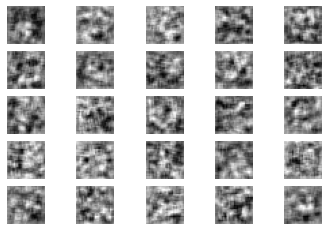

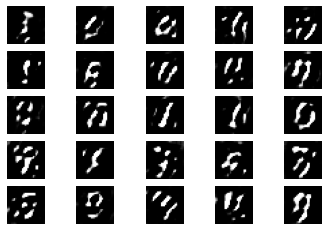

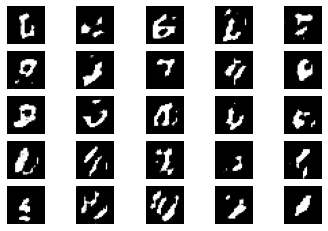

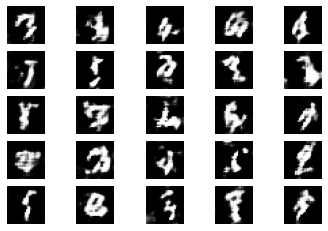

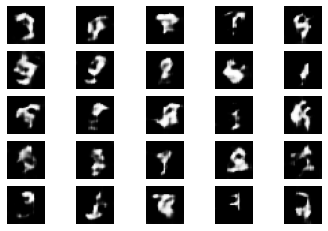

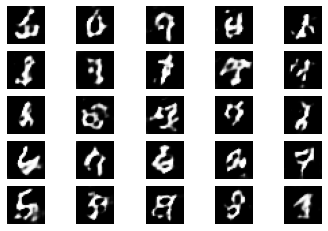

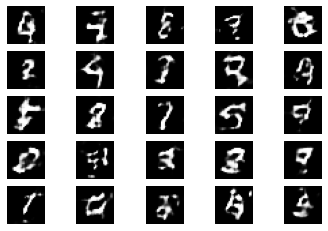

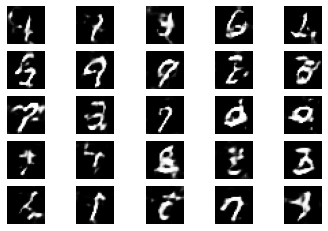

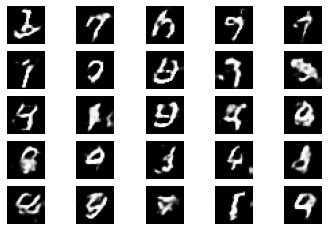

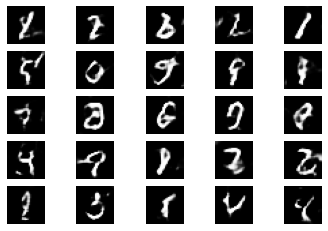

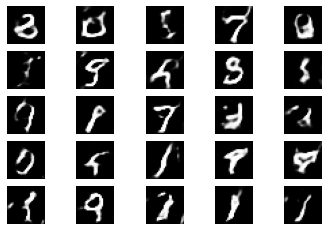

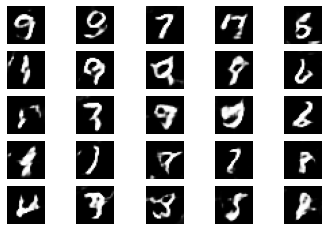

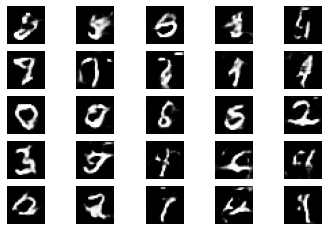

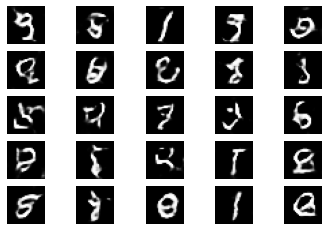

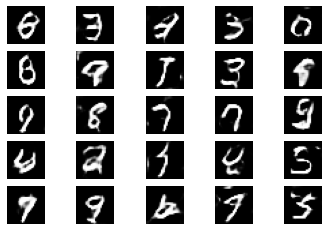

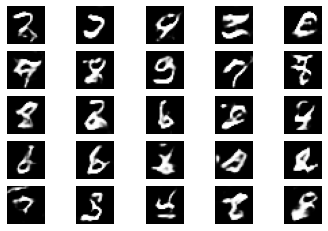

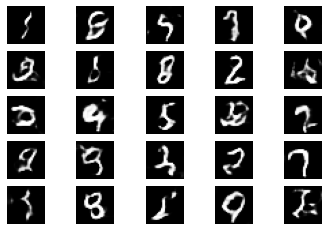

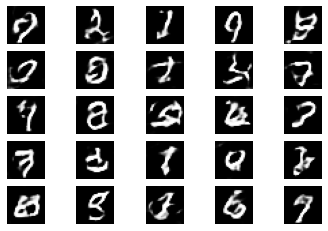

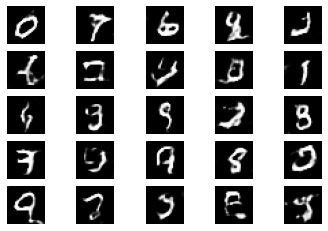

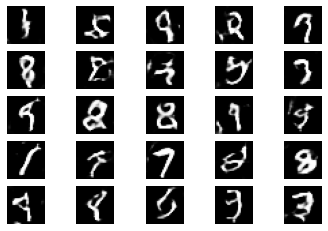

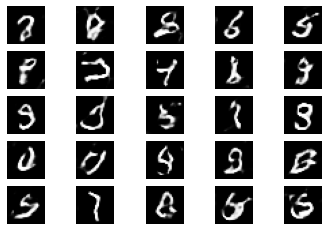

In [15]:
gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.